In [111]:
import os
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from scipy.stats import linregress
import umap
import seaborn as sns
from itertools import cycle, islice

from sklearn.cluster import MeanShift, AgglomerativeClustering, DBSCAN, SpectralClustering, KMeans

## Введение в single-cell анализ

Single - cell анализ подразумевает рассмотрение профилей экспрессии с тех или иных генов по РНК. Происходит прочтение свободных молекул РНК в клетке: для каждой такой молекулы, сохраняется маленькая техническая последовательность, уникальная для каждой
клетки (баркод), к этому дополнительно сохраняется уникальный идентификатор каждой молекулы РНК $⇒$ Получается полное количественное представление определенных РНК в клетках. Таким образов, типичные данные, которые мы получаем после одного
эксперимента, &mdash; это большая таблица, где строки &mdash; это клетки, а столбцы &mdash; гены, и в ячейке $(i,j)$ содержится
число, которое показывает количество РНК гена j в клетке i.


### Как выглядят данные:

- ~20,000 - 30,000 признаков
- высокая разреженность данных
- много пропущенных данных (дропаут)
- разный масштаб признаков



Ход работы:
 - Удаление выбросов, стандартизация данных
 - Нахождение вариабильных признаков (а значит, несущих информацию)
 - Понижение размерности с помощью линейных методов (PCA)
 - Проецирование в двумерное пространство с помощью UMAP
 - Кластеризация
 - Определение кластеров по маркерам и аннотация.


#### Шаг 1: Подготовка
Загрузка данных. 
Мы воспользуемся данными о секвенировании РНК 2700 периферических мононуклеарных клеток крови.

Эти данные  &mdash;  датасет переферических клеток крови (в основном &mdash;  лимфоциты и моноциты, клетки имунной системы), где каждая строчка  &mdash;  это отдельный ген, каждый столбец &mdash;  отдельная клетка. Дополнительно к этому датасету идут два файла, с названиями генов и индексами клеток. Наша задача будет понять, из каких кластеров состоят наши данные и сможем ли мы выделить биологически осмысленные группы.

Скачаем данные из архива.

In [2]:
matrix_dir = ""

In [3]:
genes_path = os.path.join(matrix_dir, "genes.tsv")  #названия генов
matrix_path = os.path.join(matrix_dir, "matrix.mtx")
barcodes_path = os.path.join(matrix_dir, "barcodes.tsv")  #индексы клеток

In [4]:
# Загружаем матрицу, баркоды, аннотацию для генов

mat = np.array(scipy.io.mmread(matrix_path).todense()) 
annotation = pd.read_csv(genes_path, sep='\t',header=None)
annotation.columns = ['ensemble_id','gene_symbol']
barcodes = [line.strip() for line in open(barcodes_path, 'r')]    #сохраняем баркоды удаляя пробельные символы
mat = mat.T  # хотим матрицу размера (samples, features)  #cтроки - клетки, столбцы - отдельные молекулы РНК

Посмотрим на загруженные объекты:

In [5]:
mat.shape, len(barcodes), annotation.shape

((2700, 32738), 2700, (32738, 2))

Для каждой клетки имеем 32738 столбцов, но конкретных ридов для отдельной клетки может быть меньше, так множество экспрессируемых генов для каждой клетки может и пересекаться с другой, но совпадать не обязаны.


In [6]:
annotation.head()

,ensemble_id,gene_symbol
0,ENSG00000243485,MIR1302-10
1,ENSG00000237613,FAM138A
2,ENSG00000186092,OR4F5
3,ENSG00000238009,RP11-34P13.7
4,ENSG00000239945,RP11-34P13.8


In [7]:
mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
barcodes[1:5]

['AAACATTGAGCTAC-1',
 'AAACATTGATCAGC-1',
 'AAACCGTGCTTCCG-1',
 'AAACCGTGTATGCG-1']

#### Шаг 2: Визуализация данных. 
Построим распределение суммарного количества транскриптов в каждой клетке и для каждого гена в логарифмических координатах.

Hist cells


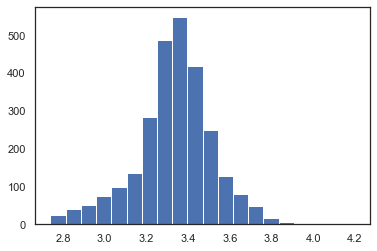

Hist genes


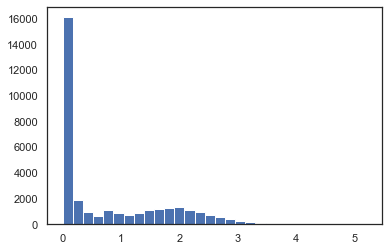

Hist genes without zeros


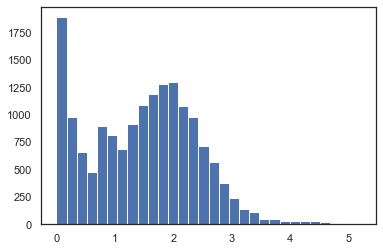

Mean cells: 2366.90037037037
Median cells: 2197.0
Std cells: 1094.0594161195556

Mean genes: 195.20529659722646
Median genes: 1.0
Std genes: 2301.4474522973137



In [87]:
sum_cells = mat.sum(axis=1)  #суммарное количество транскриптов в каждой клетке
sum_genes = mat.sum(axis=0)  #cколько транскриптов пришлось на каждый ген

sum_cells += 1  #чтоб не брать логарифм от 0
sum_cells = np.log10(sum_cells)
sum_genes += 1
sum_genes = np.log10(sum_genes)

print('Hist cells')
plt.hist(sum_cells, bins=20)
plt.show()

print('Hist genes')
plt.hist(sum_genes, bins=30)
plt.show()

print('Hist genes without zeros')
plt.hist(np.log10(mat.sum(axis=0)[mat.sum(axis=0)!=0]), bins=30)
plt.show()


for (arr, name) in zip([mat.sum(axis=1), mat.sum(axis=0)], ['cells', 'genes']):
    print('Mean '+name+':', np.mean(arr))
    print('Median '+name+':', np.median(arr))
    print('Std '+name+':', np.std(arr))
    print()



Распределение по клеткам в логарифмических координатах даже похоже на нормальное и относительно симметрично с узким пиком на экспрессии около $10^{3,4}$. Для распределения по генам легко видеть что примерно половина всех генов не экспрессируется (высокий отстоящий столбец, соответствующий нулевой экспрессии). Само распределение имеет форму с двумя пиками около 1 и 100 по порядку величины экспрессии.

#### Шаг 3: Фильтрация данных. 
Уберем из датасета клетки с суммарной экспрессией менее 250 или более чем 5000. Эти клетки, предположительно, выбросы.

In [94]:
mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [95]:
X = mat[(mat.sum(axis = 1)>=250) * (mat.sum(axis = 1)<=5000)]
print(f'Осталось {X.shape[0]} клеток')

Осталось 2631 клеток


Оставим также только те гены, в которых суммарная экспрессия ненулевая.

In [96]:
X = X[:, X.sum(axis=0)!=0]
X.shape

(2631, 16455)

#### Шаг 4: Выбор наиболее вариабельных генов
Признаков(генов) много, работать с таким количеством тяжело, поэтому выберем наиболее вариабельные.

Вариабельные гены == гены, дисперсия значений которых значительно больше, чем можно было бы ожидать по их **средней** экспрессии. Мы предполагаем, что именно такие гены будут нести информацию, так как нам не нужны гены, которые экспрессируются на одном уровне во всех клетках &mdash; они не помогут нам разделить кластеры клеток по экспрессии.   

1. Посчитаем стандартное отклонение и среднее по "сырым" данным, нам не нужны гены где эти данные равны нулю. Для среднего уже выполнено: удалены клетки где суммарная экспрессия нулевая

 $mean = \frac{sum}{kolvo}$ 


In [97]:
X = X[:, np.std(X, axis=0) !=0] # cчитаем дисперсию для каждого гена, получем boolean массив на строки с ненулевой дисперсией

2. Построим линейную модель, где зависимая переменная  &mdash; стандартное отклонение гена, а предиктор &mdash; среднее значение экспрессии: $\sigma$(mean)


In [98]:
from sklearn.linear_model import LinearRegression

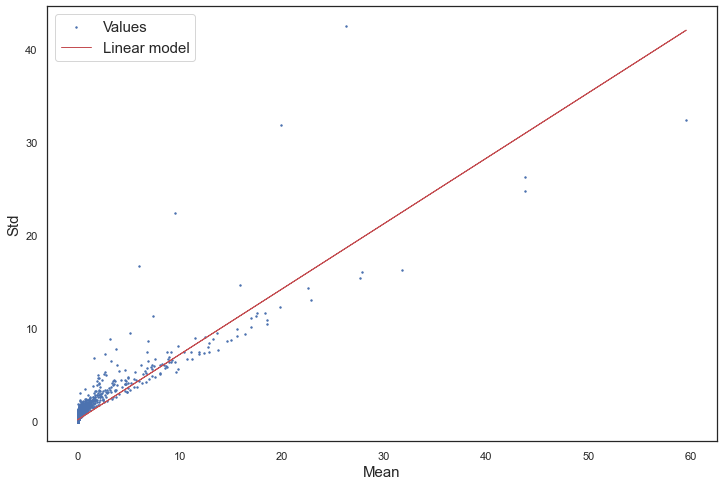

In [99]:
reg = LinearRegression()
stds = np.std(X, axis=0)
means = np.mean(X, axis=0)
reg.fit(means.reshape(-1, 1) , stds)
stds_pred = reg.predict(means.reshape(-1, 1))

plt.figure(figsize=(12,8))
plt.scatter(means, stds, 2, label='Values')
plt.plot(means, stds_pred, c='r', lw=1, label='Linear model')
plt.xlabel('Mean', fontsize=15), plt.ylabel('Std', fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [100]:
from sklearn.metrics import  mean_absolute_error as MAE
from sklearn.metrics import  mean_squared_error as MSE
from sklearn.metrics import  mean_absolute_percentage_error as MAPE

In [101]:
print('MSE:', np.round(MSE(stds, stds_pred),3))
print('MAE:', np.round(MAE(stds, stds_pred),3))
print('MAPE:', np.round(MAPE(stds, stds_pred),3))

MSE: 0.181
MAE: 0.178
MAPE: 2.354


3. Нормализация данных

Из матрицы с сырыми данными вычтем среднее для каждого гена, поделим на стандартное отклонение, но не посчитанное по данным, а на **предсказанное моделью**. Получим нормализованную версию таблицы. Если бы мы делили на выборочное стандартное отклонение, то в этой нормализованной версии таблицы стандартное отклонение каждого гена было бы равно 1 по ЦПТ. Тут же это не так.   


In [102]:
X_norm = (X - means) / stds_pred
stds_norm = X_norm.std(axis=0)
print(X_norm.std(axis=0), ((X - means) / stds).std(axis=0))
X_norm.shape

[0.29554858 0.17222488 0.17222488 ... 0.09974336 0.91965891 0.73292013] [1. 1. 1. ... 1. 1. 1.]


(2631, 16455)

4. Отсортируем гены по этому отклонению, выберем первые 2000.  

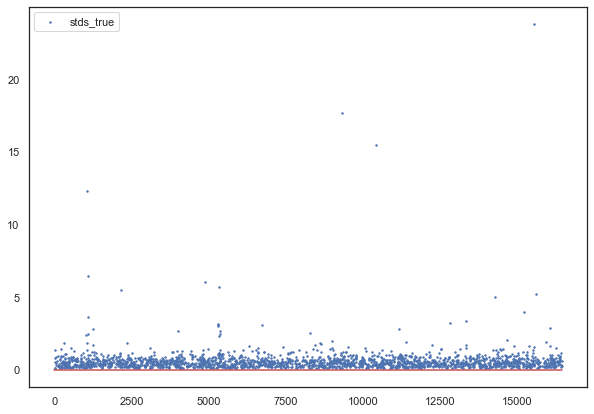

In [103]:
ind2000 = np.argsort(stds_norm)[-2000:]  #позиции нормализованных данных в отсортированном stds_norm
plt.figure(figsize=(10,7))
plt.scatter(ind2000, stds[ind2000]-stds_pred[ind2000], s=2, label='stds_true') 
plt.plot([0,max(ind2000)], [0,0], c='r')  # 0== stds_pred[ind2000]- stds_pred[ind2000]
plt.legend()
plt.show()

Как и ожидалось, для всех выбранных генов выборочная дисперсия больше, чем предсказанная моделью. Собственно это мы и хотели получить, раз выбирали гены, которые более варибельны, чем можно было бы ожидать по их средней экспрессии.

#### Шаг 5: Понижение размерности
Несмотря на то, что мы отобрали крайне вариабельные гены, они вполне могут быть скоррелированны, поэтому мы хотим найти новые "координаты", которых меньше, но которые почти так же хорошо описывают наши данные, используя метод PCA.

1. Отмасштабируем данные (выбранные гены) с помощью StandartScaler (чтобы у признаков были одинаковые среднее и дисперсия);
2. Обучаем PCA;
3. Построим график доли информации (доля от общей дисперсии) от количества компонент и найдём место, где она выходит на плато(для получения числа "нужных" компонент).

In [21]:
from sklearn.preprocessing import StandardScaler

In [23]:
X2 = X[:, ind2000]
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)

In [24]:
pca200 = PCA(n_components=50) #для начала возьмём 50 компонент
Y200 = pca200.fit_transform(X2_scaled)

Text(0, 0.5, 'Varience explained by components (%)')

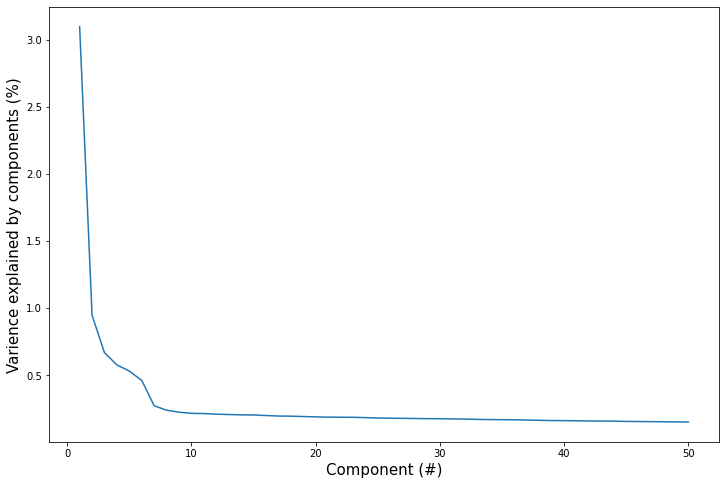

In [25]:
plt.figure(figsize=(12, 8))
grid = np.arange(50)+1
plt.plot(grid, pca200.explained_variance_ratio_*100, 
         label='')
plt.xlabel('Component (#)', fontsize=15)
plt.ylabel('Varience explained by components (%)', fontsize=15)

Видно, что основную информацию вносят первые 10 компонент, поэтому в дальнейшем будем использовать PCA с n_components=10.

#### Шаг 6: Проекция в двумерное пространство. 
Далее для визуализации спроецируем наши данные, полученные после PCA, на двумерное пространство. Для этого воспользуемся UMAP с параметрами n_neighbors=25, min_dist=0.5, learning_rate=0.5, metric='euclidean'(параметры подобраны) и его методом fit_transform. Нанесем на график проекции клеток:

In [26]:
pca10 = PCA(n_components=10) #по полученным выше результатам используем 10 компонент
Y10 = pca10.fit_transform(X2_scaled)

In [33]:
from umap.umap_ import UMAP #должен быть установлен umap-learn

In [38]:
Y_umap10 = UMAP(n_components=2, # в двумерное пространство
                n_neighbors=25, #для подсчета метрики метода
                min_dist=0.5,  
                 learning_rate=0.5,
                metric='euclidean').fit_transform(Y10)  #Обучился на данных Y10, вернул их сжатое представление
#Y_umap10 задает координаты точек в двумерном пространстве

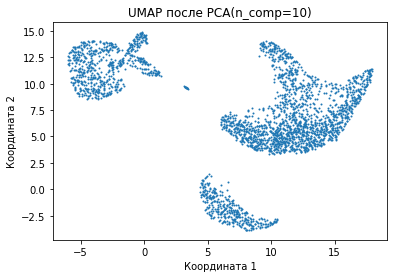

In [39]:
plt.scatter(Y_umap10[:, 0], Y_umap10[:, 1], s=1)
plt.xlabel('Координата 1')
plt.ylabel('Координата 2')
plt.title('UMAP после PCA(n_comp=10)')
plt.show()

#### Шаг 7: кластеризация клеток

Далее попробуем кластеризовать наши клетки. Делать это можно различными методами. При этом нам неизвестно как должен выглядеть конечный результат кластеризации, поэтому пробуем различные алгоритмы и смотрим на результат. 
Кластеризовать будем в выбранном пространстве после PCA, а затем наносить на двумерное пространство после UMAP. Протестируем алгоритмы  кластеризации, такие как MeanShift, AgglomerativeClustering, DBSCAN, Ward, SpectralClustering и k-means.

1. **PCA**

2. **Кластеризация**

3. **UMAP**

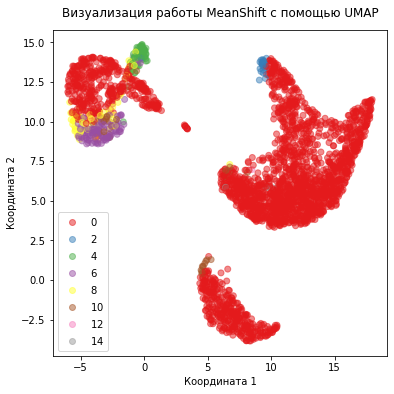

In [49]:
fig = plt.figure(figsize=(6, 6))

model_ms = MeanShift(bin_seeding=True)
y_pred_ms = model_ms.fit_predict(Y10)

scatter_ms = plt.scatter(Y_umap10[:, 0], Y_umap10[:, 1], c=y_pred_ms, cmap='Set1', alpha=0.5)
plt.xlabel('Координата 1', fontsize=10)
plt.ylabel('Координата 2', fontsize=10)
plt.legend(*scatter_ms.legend_elements())
plt.title('Визуализация работы MeanShift с помощью UMAP', y=1.02)
plt.show()

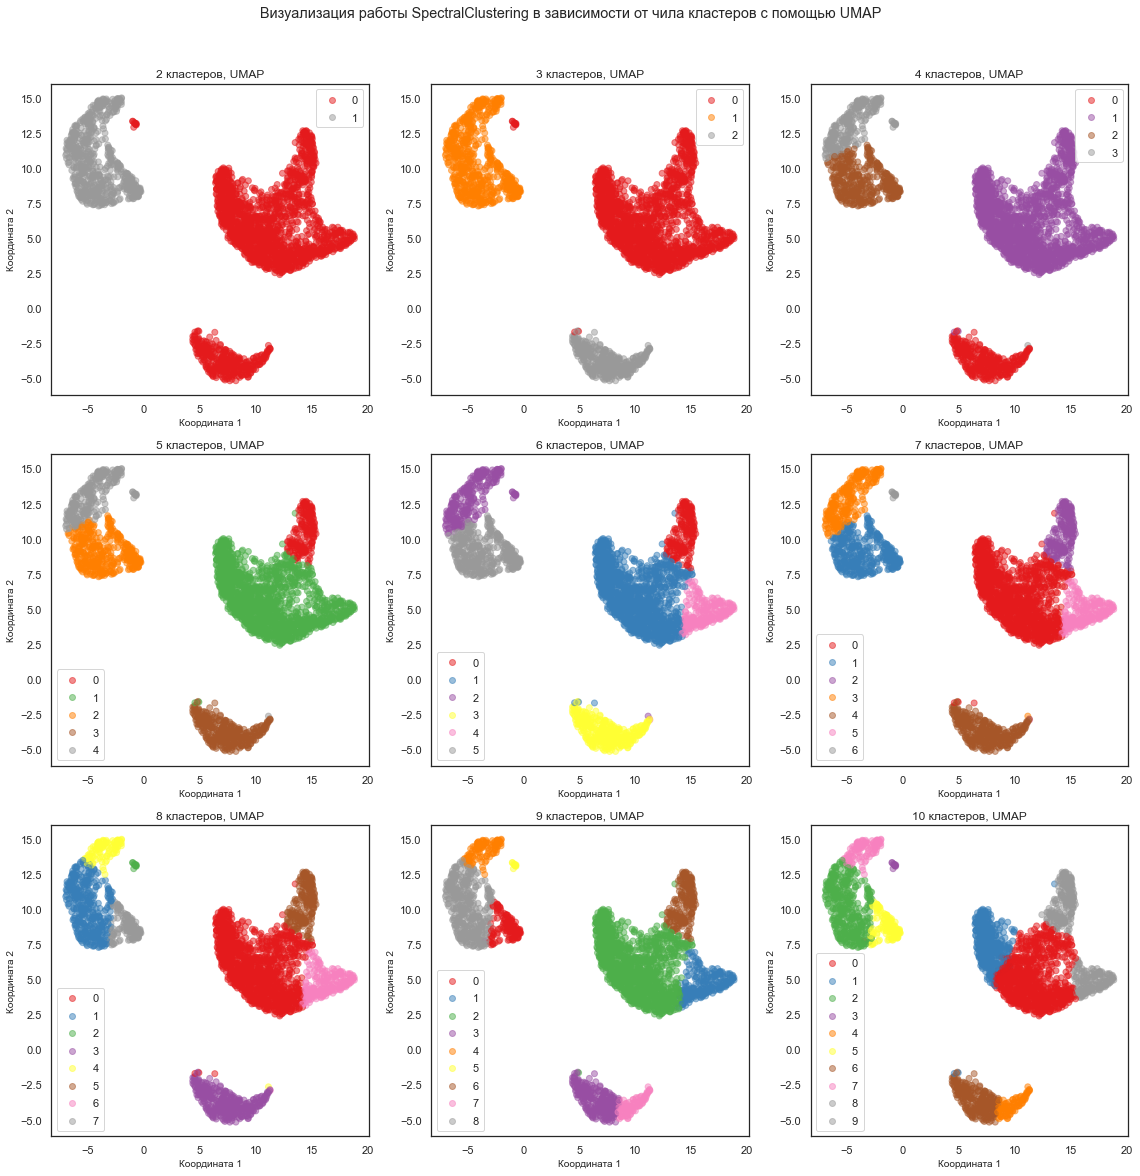

In [113]:
fig = plt.figure(figsize=(16, 16))

for n in range(2, 11): #посмотрим как разбивается картина в случае разного количества кластеров
    # Предсказание
    spectral = SpectralClustering(n_clusters=n, eigen_solver="arpack", affinity="nearest_neighbors",)
    y_pred = spectral.fit_predict(Y10)
    
    # Визуализация
    plt.subplot(3, 3, n - 1)
    scatter = plt.scatter(Y_umap10[:, 0], Y_umap10[:, 1], c=y_pred, cmap='Set1', alpha=0.5)
    plt.title(f'{n} кластеров, UMAP')
    plt.xlabel('Координата 1', fontsize=10)
    plt.ylabel('Координата 2', fontsize=10)
    plt.legend(*scatter.legend_elements())

fig.suptitle('Визуализация работы SpectralClustering в зависимости от чила кластеров с помощью UMAP', y=1.02)
plt.tight_layout()

C:\Users\eliza\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:245: UserWarning: the number of connected components of the connectivity matrix is 6 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
C:\Users\eliza\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:245: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
C:\Users\eliza\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:245: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


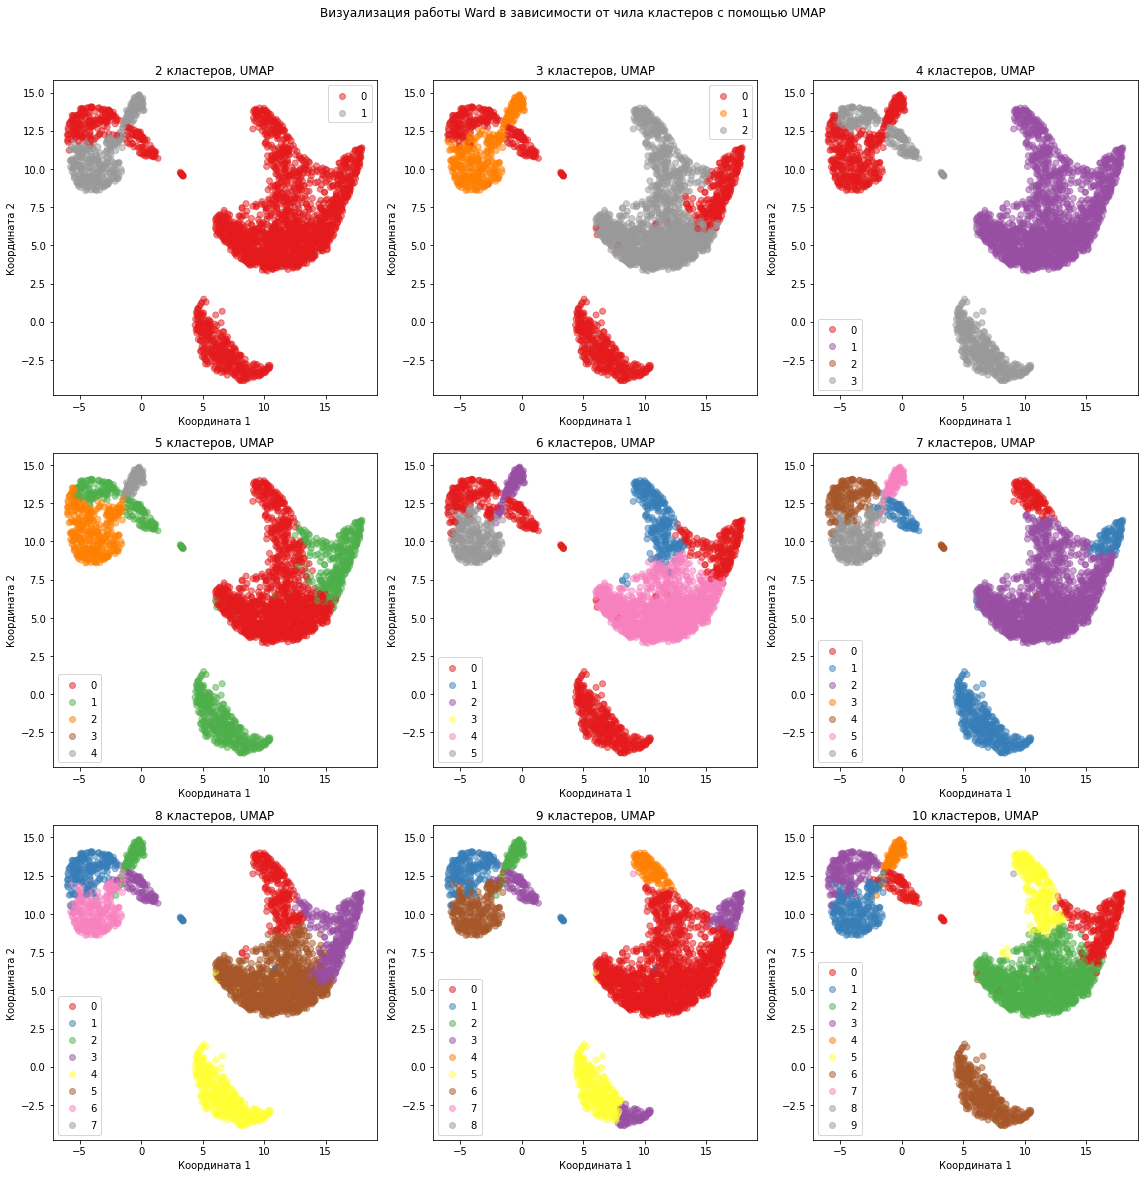

In [44]:
fig = plt.figure(figsize=(16, 16))

for n in range(2, 11):
    # матрица связности Ward
    connectivity = kneighbors_graph(
        Y10, n_neighbors=n, include_self=False
    )
    # делаем матрицу симметричной
    connectivity = 0.5 * (connectivity + connectivity.T)
    
    # Предсказание
    ward = AgglomerativeClustering(n_clusters=n, linkage="ward", connectivity=connectivity)
    y_pred = ward.fit_predict(Y10)
    
    # Визуализация
    plt.subplot(3, 3, n - 1)
    scatter = plt.scatter(Y_umap10[:, 0], Y_umap10[:, 1], c=y_pred, cmap='Set1', alpha=0.5)
    plt.title(f'{n} кластеров, UMAP')
    plt.xlabel('Координата 1', fontsize=10)
    plt.ylabel('Координата 2', fontsize=10)
    plt.legend(*scatter.legend_elements())

fig.suptitle('Визуализация работы Ward в зависимости от чила кластеров с помощью UMAP', y=1.02)
plt.tight_layout()

**Видим не очень корректное разделение по красному и фиолетовому цвету при увеличении числа кластеров.**

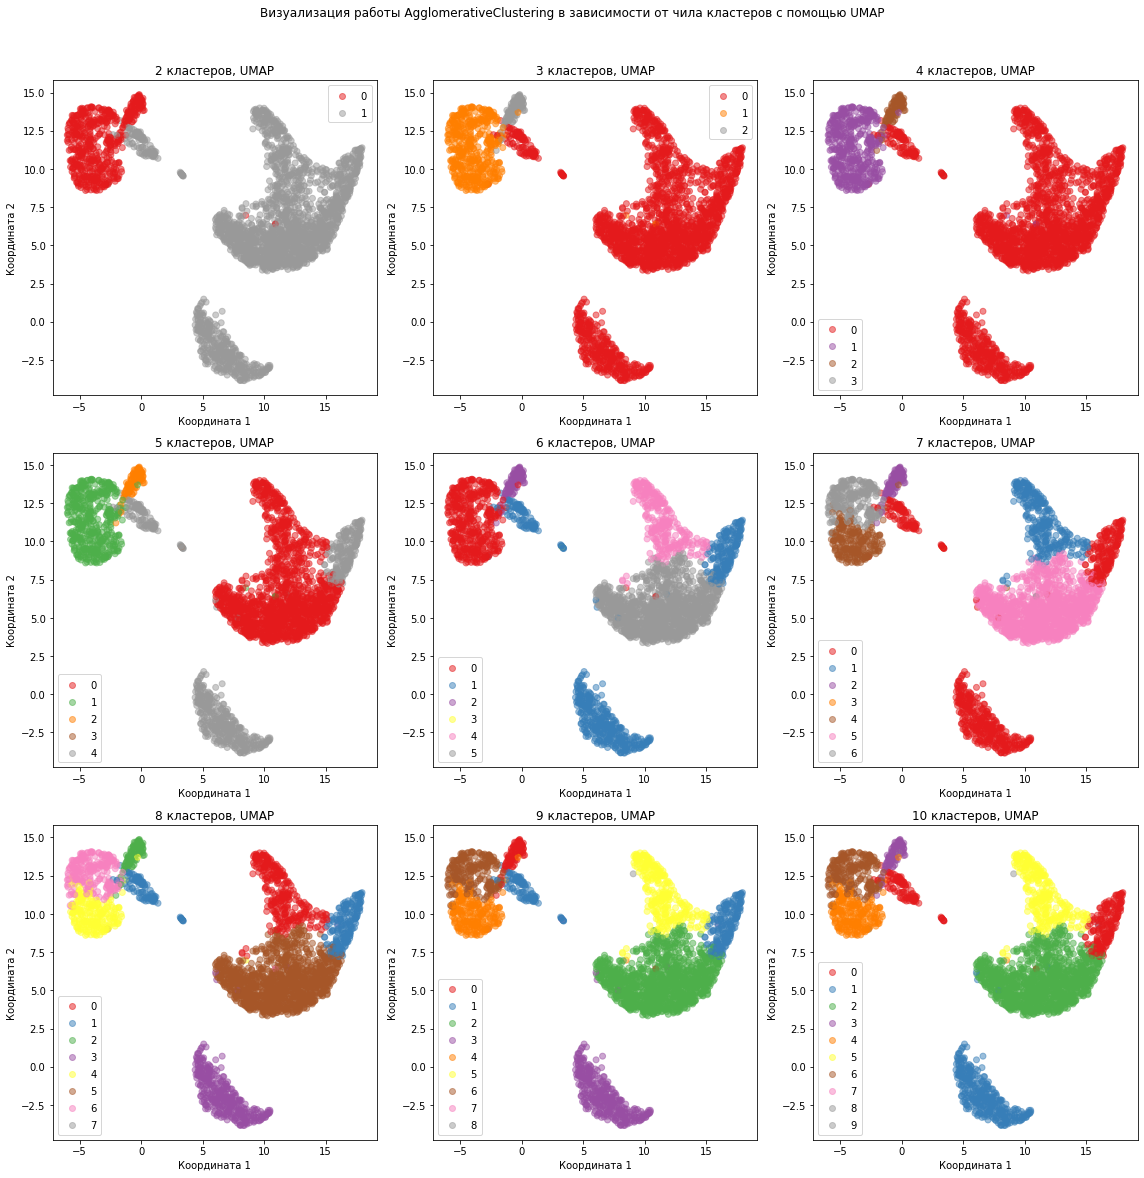

In [45]:
fig = plt.figure(figsize=(16, 16))

for n in range(2, 11):
    # Предсказание
    agglomerat = AgglomerativeClustering(n_clusters=n)
    y_pred = agglomerat.fit_predict(Y10)
    
    # Визуализация
    plt.subplot(3, 3, n - 1)
    scatter = plt.scatter(Y_umap10[:, 0], Y_umap10[:, 1], c=y_pred, cmap='Set1', alpha=0.5)
    plt.title(f'{n} кластеров, UMAP')
    plt.xlabel('Координата 1', fontsize=10)
    plt.ylabel('Координата 2', fontsize=10)
    plt.legend(*scatter.legend_elements())

fig.suptitle('Визуализация работы AgglomerativeClustering в зависимости от чила кластеров с помощью UMAP', y=1.02)
plt.tight_layout()

**При n>8 разница не особо видна, странным образом выделяет синий цвет, различий в результатах с Ward'ом мало, оно и логично: у методов каркас одинаковый**

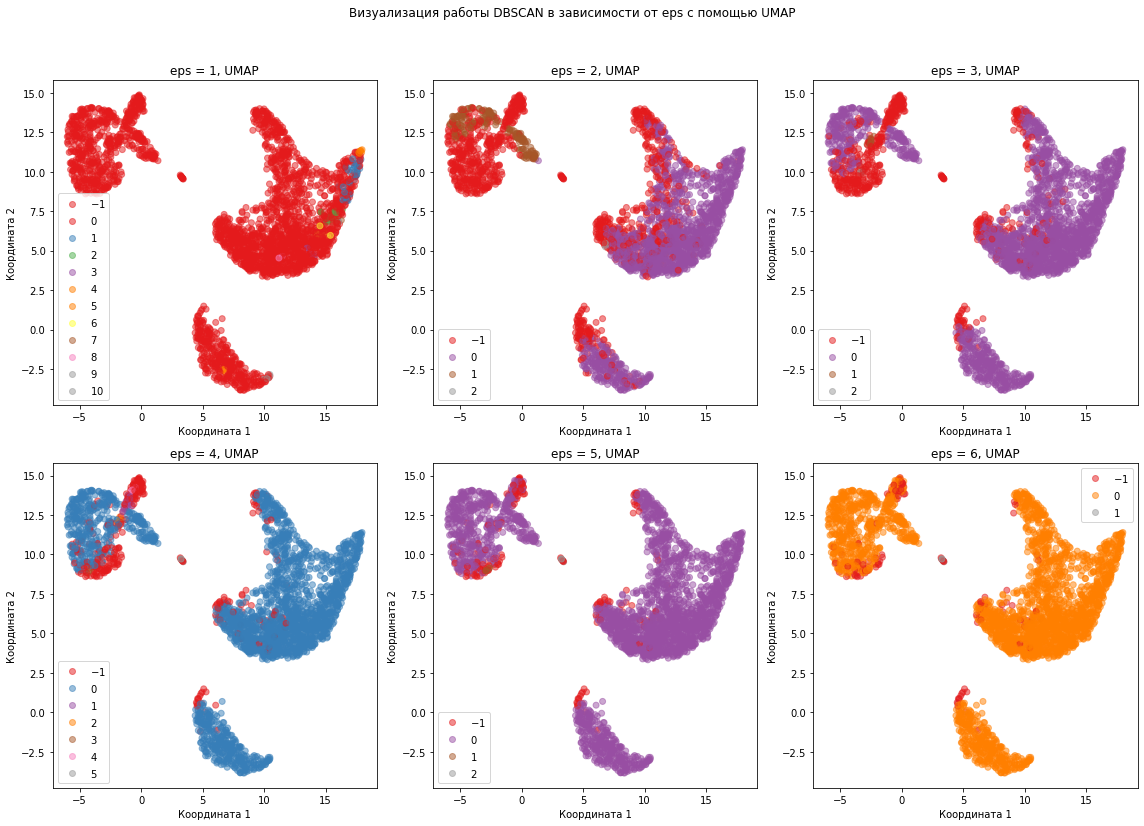

In [46]:
fig = plt.figure(figsize=(16, 16))
eps = np.arange(1, 10) # влияния min_samples не обнаружено
for n in range(2, 8):
    # Предсказание
    dbscan = DBSCAN(eps=eps[n-2])
    y_pred = dbscan.fit_predict(Y10)
    
    # Визуализация
    plt.subplot(3, 3, n - 1)
    scatter = plt.scatter(Y_umap10[:, 0], Y_umap10[:, 1], c=y_pred, cmap='Set1', alpha=0.5)
    plt.title(f'eps = {eps[n-2]}, UMAP')
    plt.xlabel('Координата 1', fontsize=10)
    plt.ylabel('Координата 2', fontsize=10)
    plt.legend(*scatter.legend_elements())

fig.suptitle('Визуализация работы DBSCAN в зависимости от eps с помощью UMAP', y=1.02)
plt.tight_layout()

**выделяет недостаточное количество кластеров, причем не очень корректно**

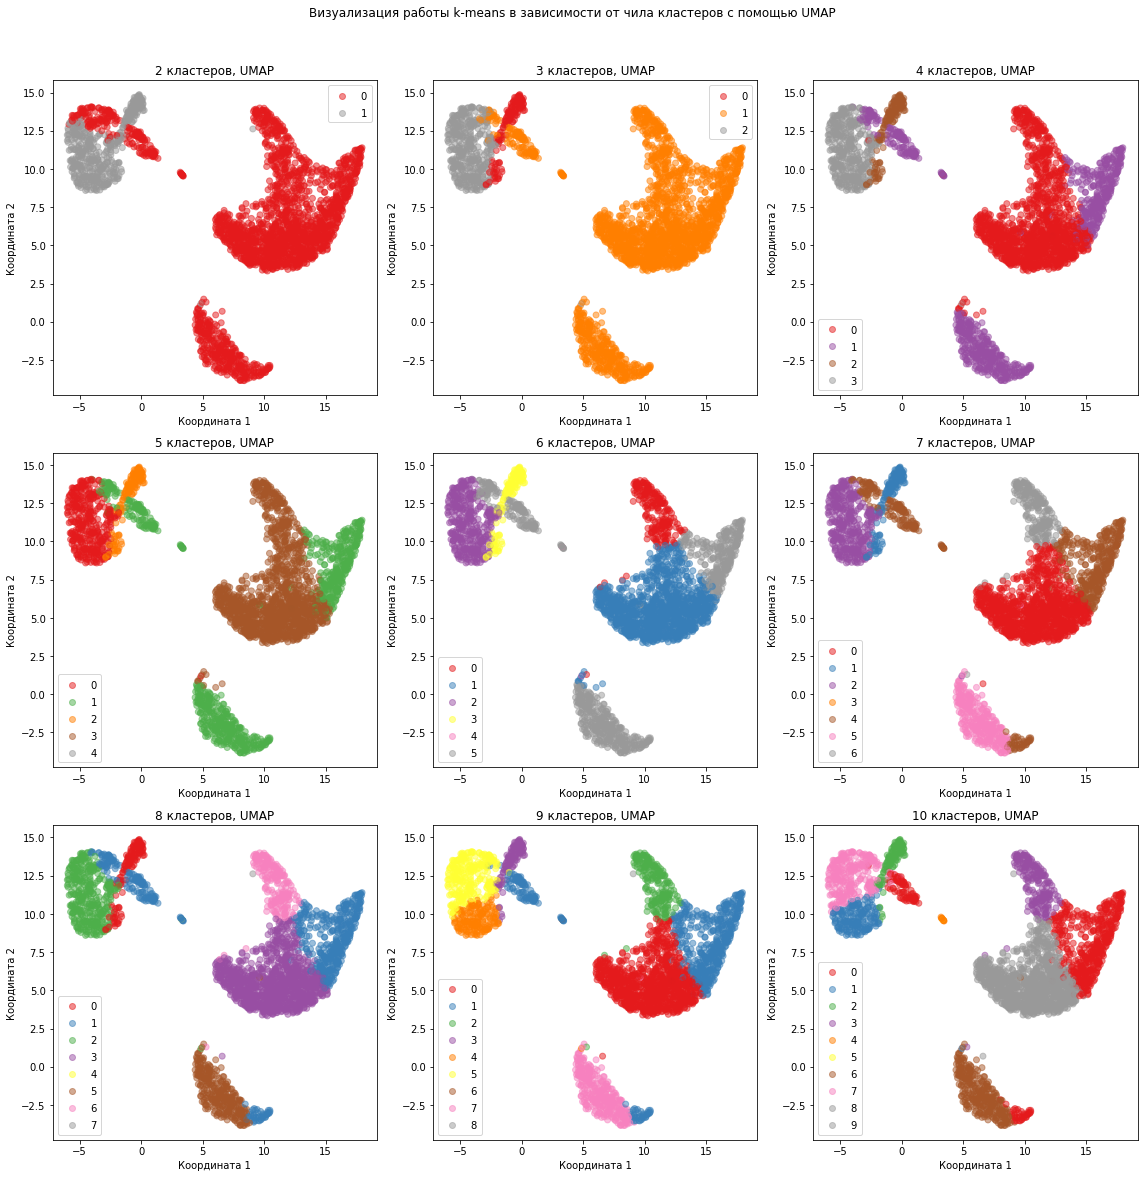

In [48]:
fig = plt.figure(figsize=(16, 16))

for n in range(2, 11):
    # Предсказание
    kmeans = KMeans(n_clusters=n, random_state=1)
    y_pred = kmeans.fit_predict(Y10)
    
    # Визуализация
    plt.subplot(3, 3, n - 1)
    scatter = plt.scatter(Y_umap10[:, 0], Y_umap10[:, 1], c=y_pred, cmap='Set1', alpha=0.5)
    plt.title(f'{n} кластеров, UMAP')
    plt.xlabel('Координата 1', fontsize=10)
    plt.ylabel('Координата 2', fontsize=10)
    plt.legend(*scatter.legend_elements())

fig.suptitle('Визуализация работы k-means в зависимости от чила кластеров с помощью UMAP', y=1.02)
plt.tight_layout()

**Итого:** получена кластеризация для различных методов при различном количестве кластеров. Данные картинки мало информативны, так как изначально мы не знаем какие кластеры есть в наших данных, поэтому нельзя понять какой метод лучше работает и с каким числом кластеров.

#### Визуализация экспрессии маркеров.

Зачастую правильного ответа, какие кластеры есть в данных - нет. Но в данном случае мы можем воспользоваться знаниями из биологии, так как мы знаем маркеры для биологических кластеров, то есть для клеток, которые физически и биологически выполняют разные функции.  Для контроля процессинга визуализируем экспрессию генов соответствующих только одному типу клеток (например, гены LYZ, CD14 (маркеры макрофагов и моноцитов), CD8A - маркер для CD8+T клеток, и так далее). Все гены типичные для определенных клеток записаны в словаре cluster_assignment.

In [114]:
cluster_assignment = dict({'Memory CD4+':['IL7R', 'CCR7'],
                          'Naive CD4+ T' : ['IL7R', 'S100A4'],
                          'CD14+ Mono':['LYZ','CD14'],
                          'B':['MS4A1'],
                          'CD8+ T':['CD8A'],
                          'FCGR3A+ Mono':['FCGR3A','MS4A7'],
                          'NK':['GNLY','NKG7'],
                          'DC':['FCER1A','CST3'],
                          'Mk':['PPBP']}) #гены, характерные для типов клеток

genes = annotation['gene_symbol'].to_numpy()
names = {}
names['LYZ (CD14+ mono)'] = np.where(genes=='LYZ')[0][0]
names['CD14 (CD14+ mono)'] = np.where(genes=='CD14')[0][0]
names['CD8A (CD8+ T)'] = np.where(genes=='CD8A')[0][0]
names['CCR7 (Memory CD4+)'] = np.where(genes=='CCR7')[0][0]
names['S100A4 (Naive CD4+ T)'] = np.where(genes=='S100A4')[0][0]
names['MS4A1 (B)'] = np.where(genes=='MS4A1')[0][0]
names['MS4A7 (FCGR3A+ Mono)']=np.where(genes=='MS4A7')[0][0]
names['FCGR3A (FCGR3A+ Mono)'] = np.where(genes=='FCGR3A')[0][0]
names['GNLY (NK)']=np.where(genes=='GNLY')[0][0]
names['NKG7 (NK)'] =np.where(genes=='NKG7')[0][0]
names['FCER1A (DC)'] = np.where(genes=='FCER1A')[0][0]
names['CST3 (DC)']=np.where(genes=='CST3')[0][0]
names['PPBP (Mk)']=np.where(genes=='PPBP')[0][0]
 #нет IL7R7

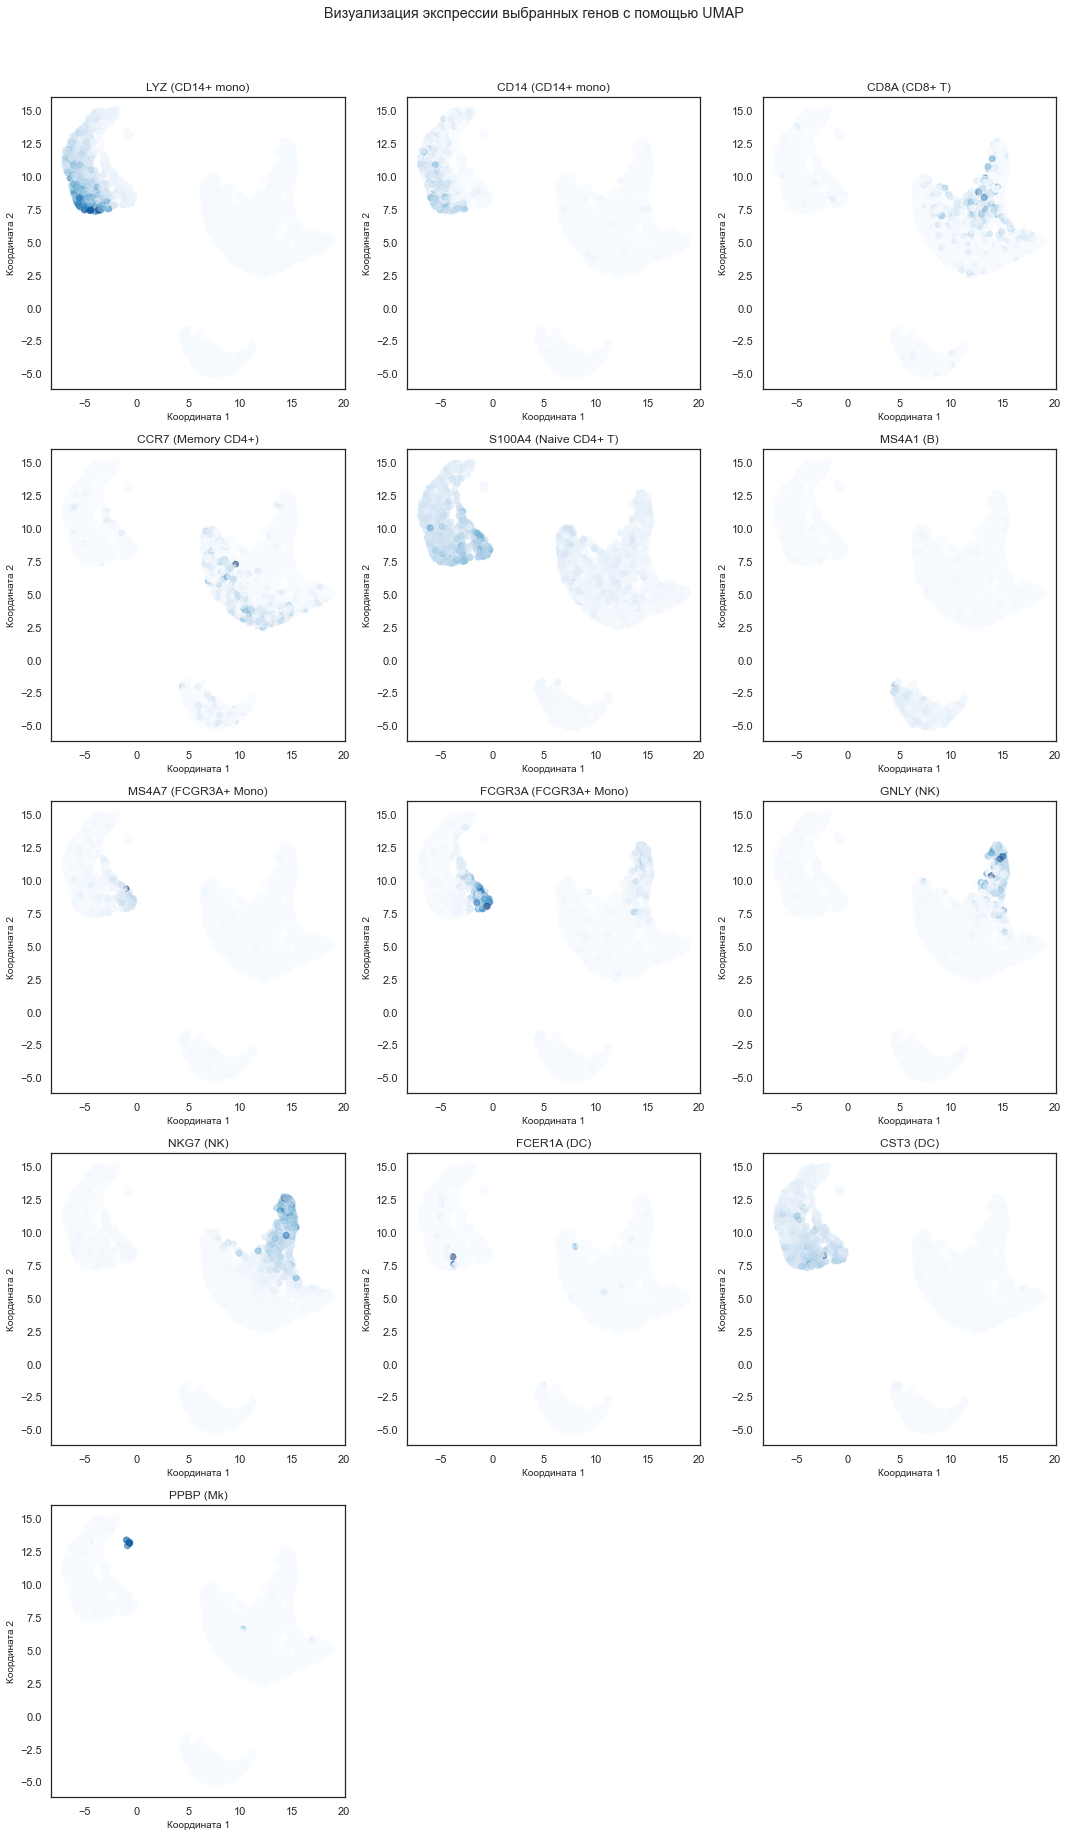

In [115]:
#визуализация экспрессии различных генов
fig = plt.figure(figsize=(15, 25))
sns.set(style='white')
for i, gene in enumerate(names.keys()):
    plt.subplot(5, 3, i+1)
    c = (mat[(mat.sum(axis = 1)>=250) * (mat.sum(axis = 1)<=5000)])[:, names[gene]]
    plt.scatter(Y_umap10[:, 0], Y_umap10[:, 1], c=c, cmap='Blues', alpha=0.5)
    plt.title(gene) #название гена (тип клетки)
    plt.xlabel('Координата 1', fontsize=10)
    plt.ylabel('Координата 2', fontsize=10)

fig.suptitle('Визуализация экспрессии выбранных генов с помощью UMAP', y=1.02)
plt.tight_layout()

На полученных графиках, можно выделить области, где экспрессируются данные маркеры. Также можно отметить, что для генов, соответствующих одинаковым типам клеток, отмечаются примерно одинаковые области. При этом разные маркеры выделяют разные области, что говорит о том, что в нашем случае кластеризация уместна.

Выберем агломеративный метод кластеризации и проверим, имеют ли биологический смысл полученные кластеры. Например, если будет только один кластер, который экспрессирует MS4A1, это значит, что мы корректно выделили B cells, если будет только один кластер, который экспрессирует CD8A, это значит, что мы корректно выделили CD8+ T и так далее.
Для этого построим для каждого кластера boxplot с его соответствующими генами:

In [55]:
def find_gene(gene, genes):
    if gene in genes:
        return np.where(genes==gene)[0][0]
    return 'no gene'

In [56]:
gene_ind ={}
for arr in cluster_assignment.values():
    for gene in arr:
        gene_ind[gene] = find_gene(gene, genes)
print(gene_ind)

{'IL7R': 8763, 'CCR7': 26957, 'S100A4': 1964, 'LYZ': 21053, 'CD14': 9633, 'MS4A1': 18944, 'CD8A': 4064, 'FCGR3A': 2237, 'MS4A7': 18941, 'GNLY': 4046, 'NKG7': 31075, 'FCER1A': 2153, 'CST3': 28817, 'PPBP': 7696}


In [117]:
temp = mat[(mat.sum(axis = 1)>=250) * (mat.sum(axis = 1)<=5000)]  #рассматриваем не выбросы
data = {gene:temp[:, gene_ind[gene]] for gene in list(gene_ind.keys())} #ген - уровень его экспрессии во всех типах клеток

n_clusters=6
agglomerat = AgglomerativeClustering(n_clusters=n_clusters)
y_pred = agglomerat.fit_predict(Y10)  #cтолбец с предсказаниями к какому кластеру относятся типы клеток

df = pd.DataFrame(data)
df.head()

,IL7R,CCR7,S100A4,LYZ,CD14,MS4A1,CD8A,FCGR3A,MS4A7,GNLY,NKG7,FCER1A,CST3,PPBP
0,3.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,16.0,24.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,22.0,1.0
4,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0,0.0,0.0


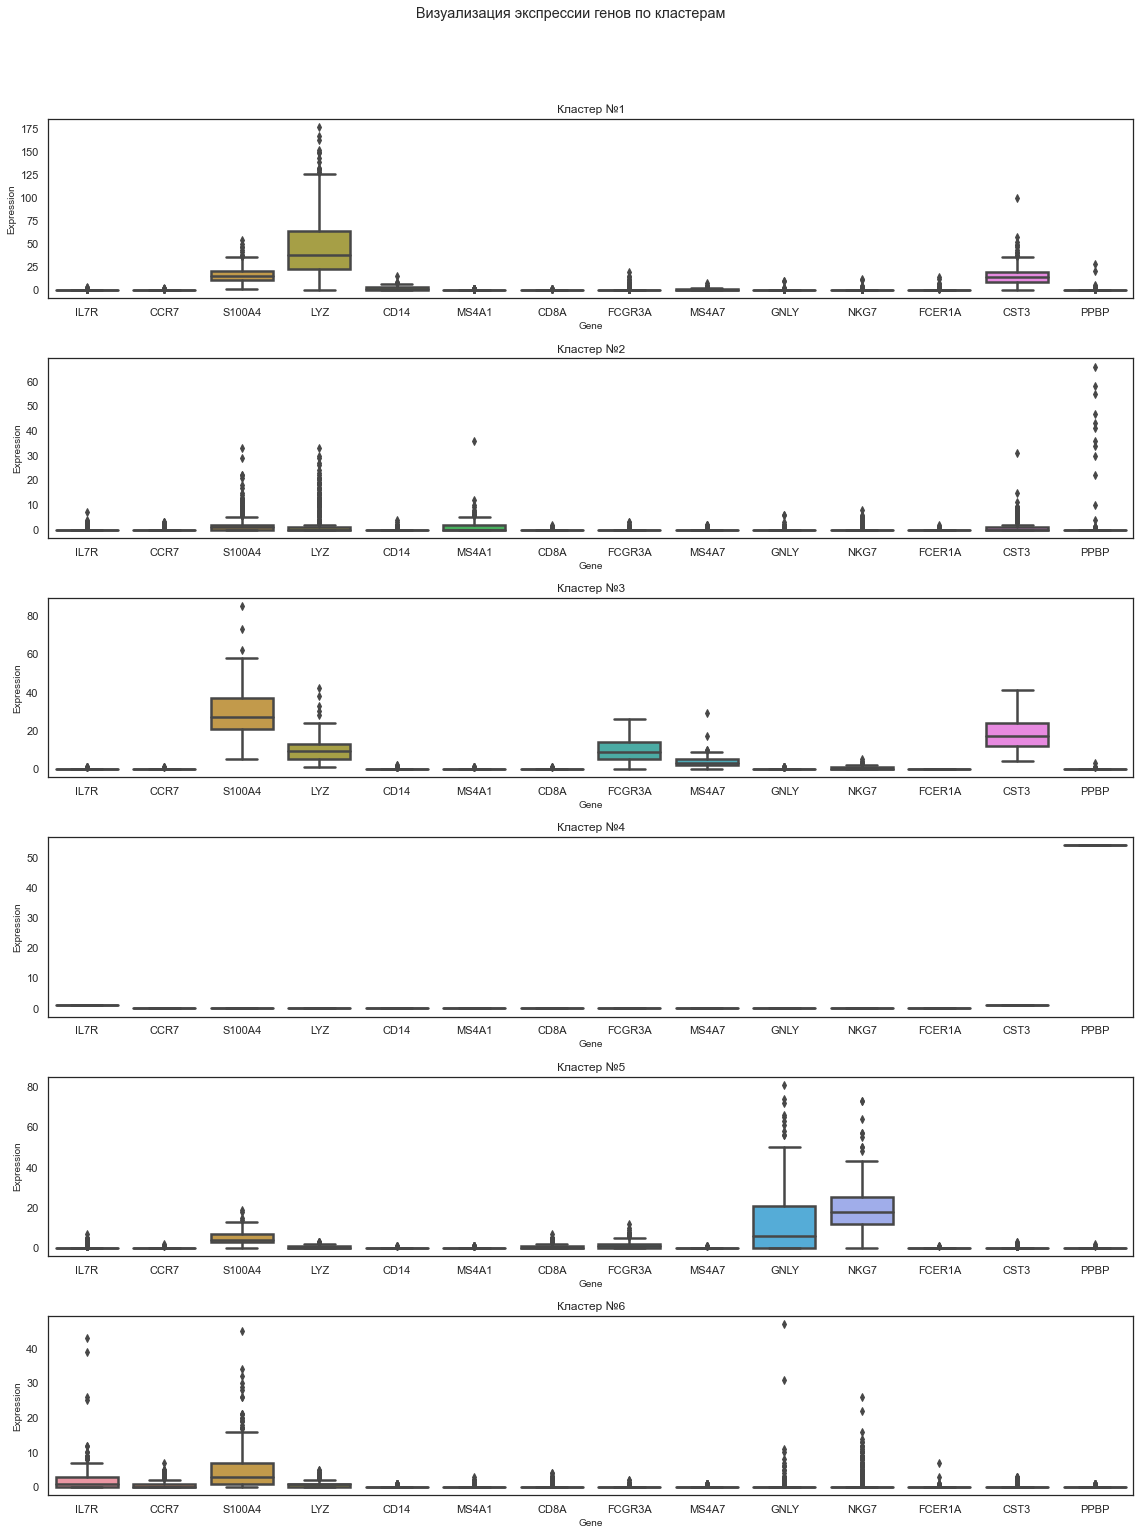

In [118]:
fig = plt.figure(figsize=(16, 40))

for n in range(1, n_clusters+1):
    df_n = df[y_pred==n-1]  #кластеру (n-1) принадлежат опредленные позиции клеток из df
    # Визуализация
    plt.subplot(12, 1, n)
    sns.boxplot(data=df_n, linewidth=2.5)
    plt.title(f'Кластер №{n}')
    plt.xlabel('Gene', fontsize=10)
    plt.ylabel('Expression', fontsize=10)
fig.suptitle('Визуализация экспрессии генов по кластерам', y=1.02)
plt.tight_layout()

Общие выводы: 




In [ ]:
cluster_assignment = dict({'Memory CD4+':['IL7R', 'CCR7'], #
                          'Naive CD4+ T' : ['IL7R', 'S100A4'], #2/6
                          'CD14+ Mono':['LYZ','CD14'], #1
                          'B':['MS4A1'], #2
                          'CD8+ T':['CD8A'], #
                          'FCGR3A+ Mono':['FCGR3A','MS4A7'], #3
                          'NK':['GNLY','NKG7'], #5
                          'DC':['FCER1A','CST3'],#
                          'Mk':['PPBP']}) #4
# цифра - номер кластера, в котором выделяется тип клеток

Некоторые кластеры можно точно охарактеризовать, например кластер номер 2 соответствует B клеткам, номер 5 - NK, 4 - Mk, 3 - моноцитам. 

Также могут присуствовать клетки других типов в малом количестве. Для их детерминации можно провести разбиение на больше число кластеров. К примеру:

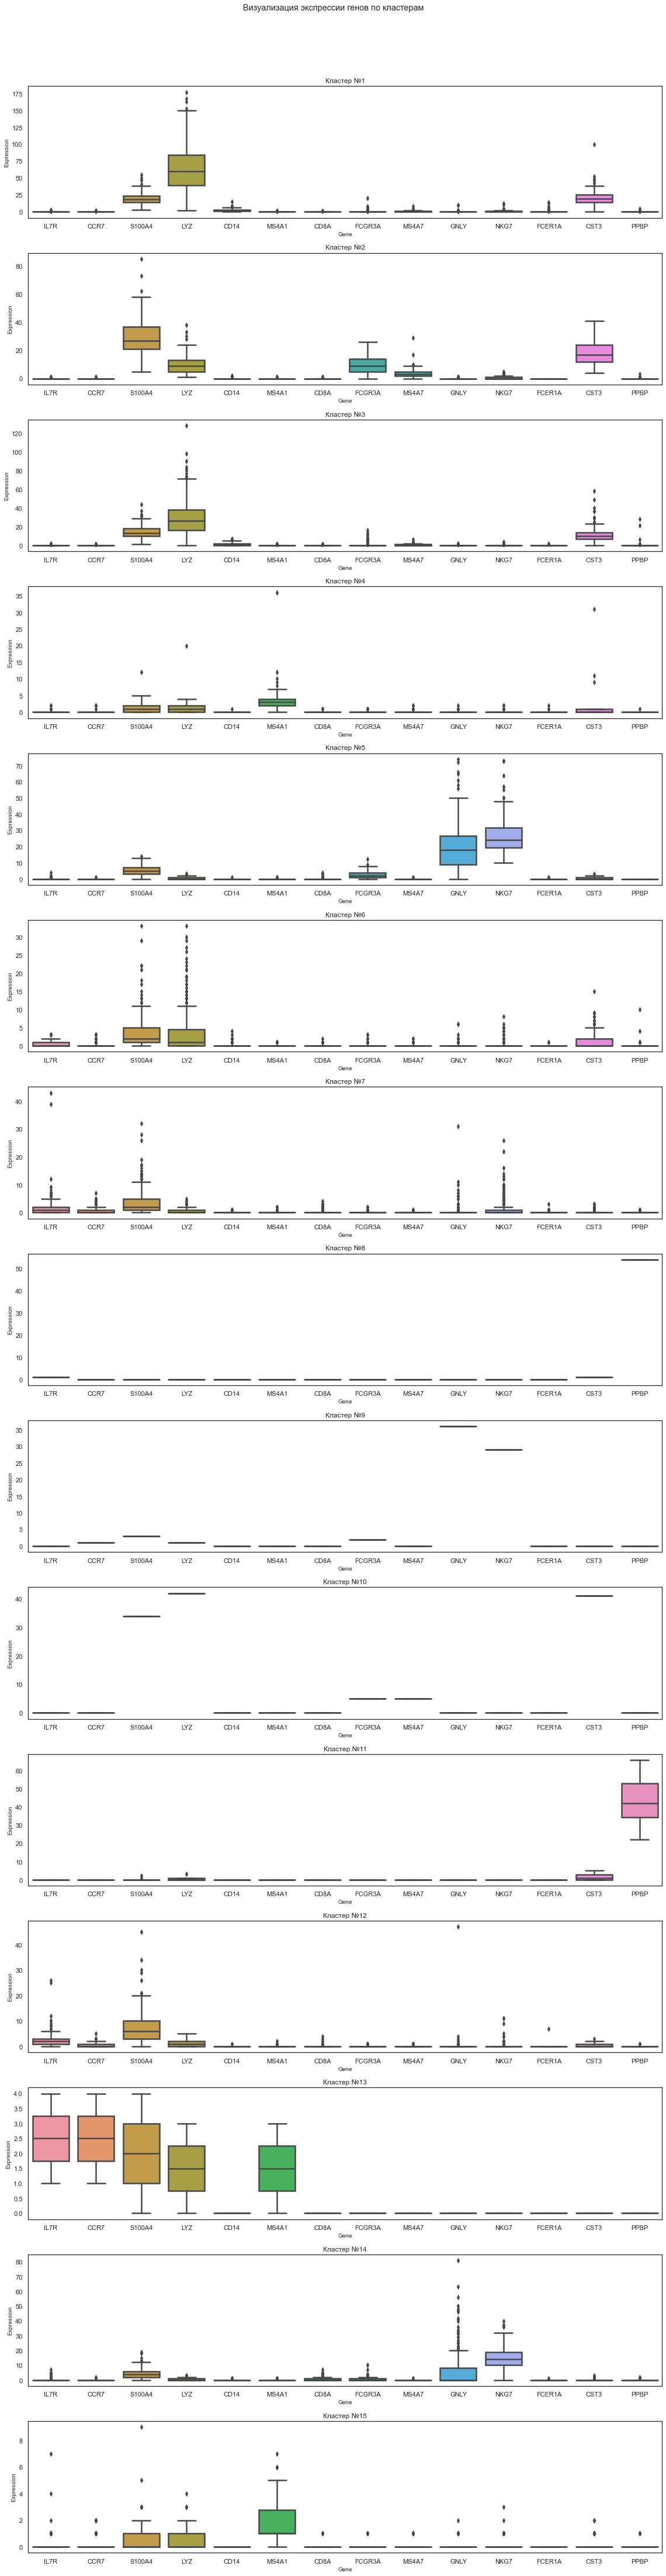

In [119]:
n_clusters=15
agglomerat = AgglomerativeClustering(n_clusters=n_clusters)
y_pred = agglomerat.fit_predict(Y10)
fig = plt.figure(figsize=(16, 60))

for n in range(1, n_clusters+1):
    df_n = df[y_pred==n-1]
    # Визуализация
    plt.subplot(15, 1, n)
    sns.boxplot(data=df_n, linewidth=2.5)
    plt.title(f'Кластер №{n}')
    plt.xlabel('Gene', fontsize=10)
    plt.ylabel('Expression', fontsize=10)
fig.suptitle('Визуализация экспрессии генов по кластерам', y=1.02)
plt.tight_layout()

In [ ]:
cluster_assignment = dict({'Memory CD4+':['IL7R', 'CCR7'], #7,12,13
'Naive CD4+ T' : ['IL7R', 'S100A4'], #6,7,12,13
'CD14+ Mono':['LYZ','CD14'], #1,3
'B':['MS4A1'], #4,13,15
'CD8+ T':['CD8A'], #
'FCGR3A+ Mono':['FCGR3A','MS4A7'], #2,10
'NK':['GNLY','NKG7'], #5,9 ,14
'DC':['FCER1A','CST3'],#
'Mk':['PPBP']}) #8,11

Тут можно заметить что NK разбивается при разделении на 3 кластера (5,9,14), CD14 моноциты разбились на 2 класса(1,3), также как и FCGR3A(2,10).Но в явном виде не удаётся выделить все 9 типов клеток, однако можно проследить присутствие определённых типов клеток в различных кластерах( СD4 наивных T клеток и CD4 клеток памяти в 13 кластере).

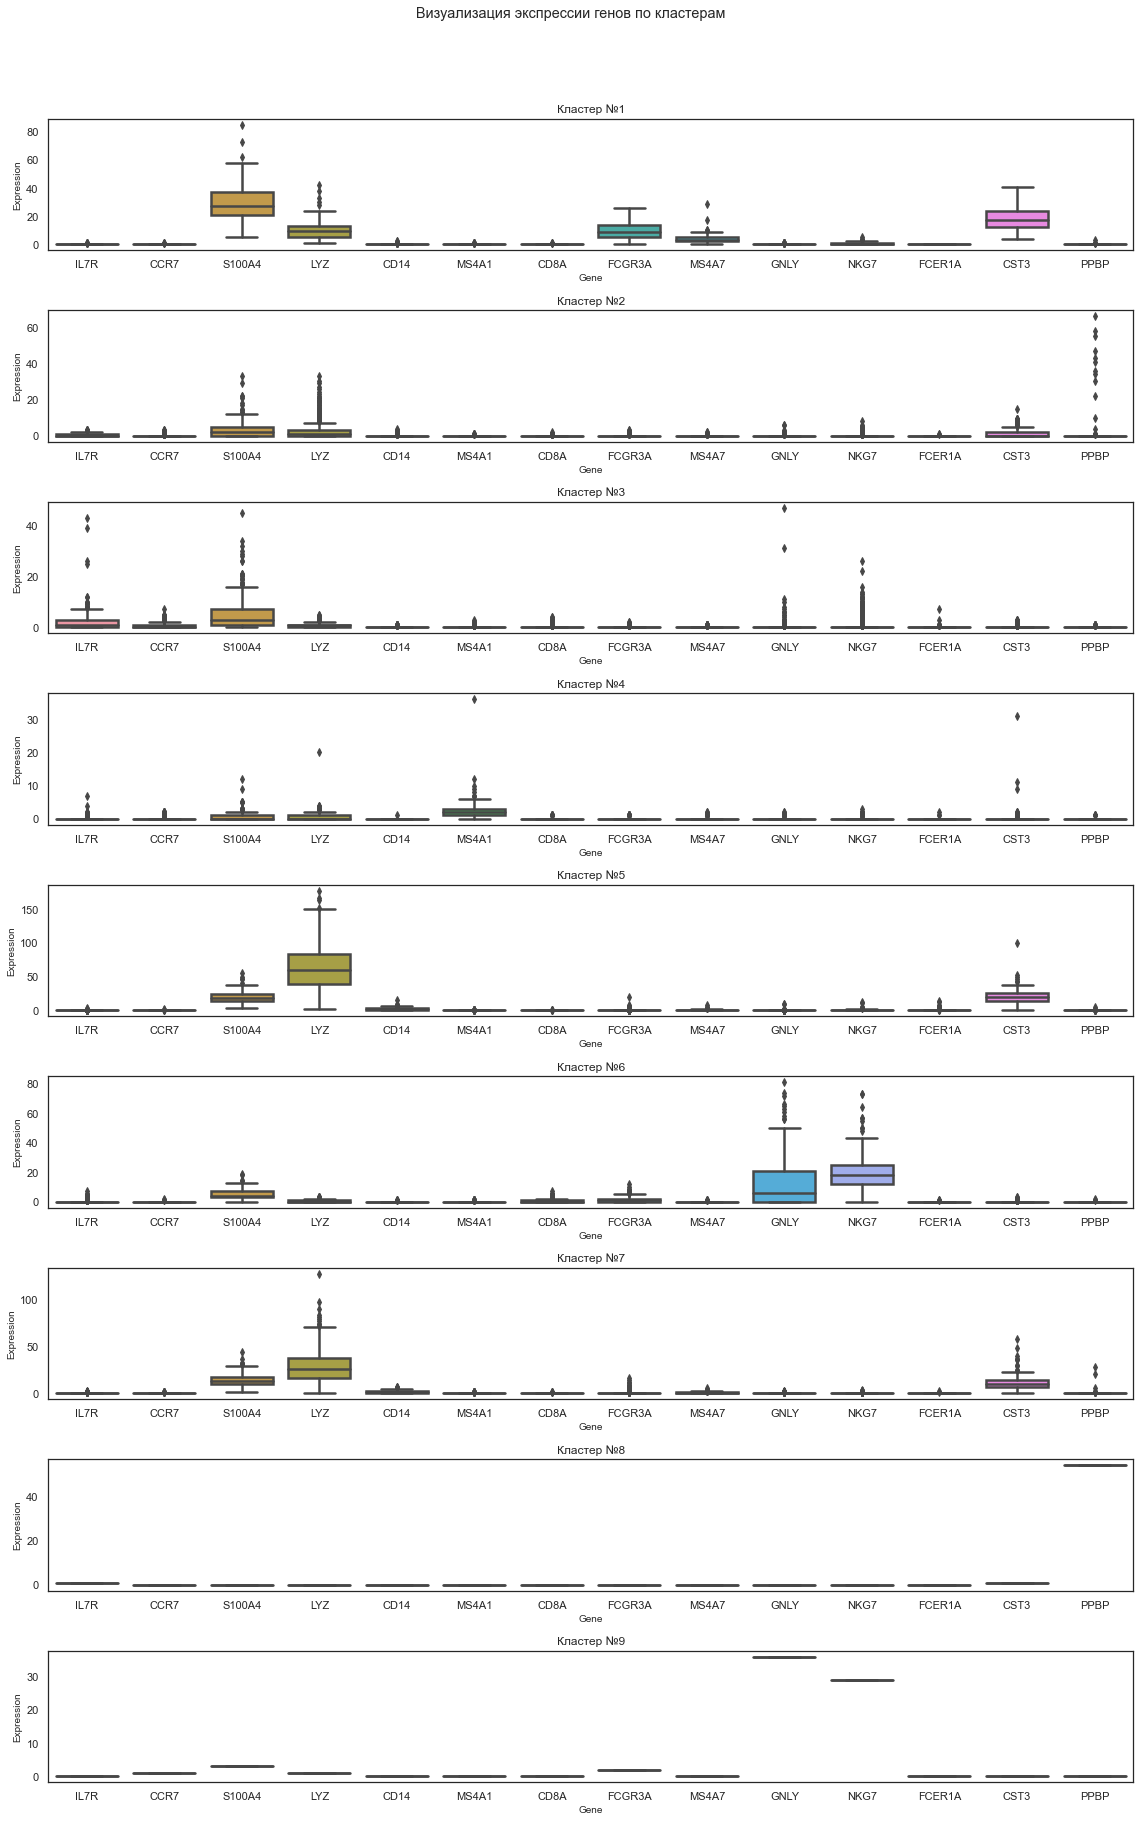

In [120]:
n_clusters=9
agglomerat = AgglomerativeClustering(n_clusters=n_clusters)
y_pred = agglomerat.fit_predict(Y10)
fig = plt.figure(figsize=(16, 40))

for n in range(1, n_clusters+1):
    df_n = df[y_pred==n-1]
    # Визуализация
    plt.subplot(15, 1, n)
    sns.boxplot(data=df_n, linewidth=2.5)
    plt.title(f'Кластер №{n}')
    plt.xlabel('Gene', fontsize=10)
    plt.ylabel('Expression', fontsize=10)
fig.suptitle('Визуализация экспрессии генов по кластерам', y=1.02)
plt.tight_layout()

In [ ]:
cluster_assignment = dict({'Memory CD4+':['IL7R', 'CCR7'], #3
'Naive CD4+ T' : ['IL7R', 'S100A4'], #3
'CD14+ Mono':['LYZ','CD14'], #5
'B':['MS4A1'], #4
'CD8+ T':['CD8A'], #
'FCGR3A+ Mono':['FCGR3A','MS4A7'], #1
'NK':['GNLY','NKG7'], #6,9
'DC':['FCER1A','CST3'],#
'Mk':['PPBP']}) #8

При разбиении на 9 кластеров можно выделить группу NK клеток (6 кластер, частично 9), Mk(8 кластер), CD4+ клетки памяти и наивные клетки (3 кластер), моноциты CD14 (предположительно 5 кластер), моноциты FCGR3A+ (1 кластер), B клетки(4 кластер). Однако разделить ровно на 9 наших типов клеток не получилось, что логично, так как соотношение разных типов клеток в крови неодинаково.

**Таким образом,** можно сделать вывод, что в случае single cell RNA seq анализа, опираясь на известные закономерности, можно определить естественность кластеризации. Найдя кластеры в которых экспрессируется лишь один характерный ген, можно определить тип клеток к которому он принадлежит.